# COVID-19 Vaccine Sentiment Analysis

The COVID-19 vaccines continue to be our best bet at ending the global pandemic that has ravaged our planet for almost two years. These vaccines may be the greatest scientific achievement of our time, but anti-vaccine movements seem to be halting vaccination campaigns around the world. Understanding how these vaccines are discussed and perceived by the general public is thus an important part of the vaccination effort. By understanding how the public talks about the vaccines, government agencies can change their messaging to assuage fears, combat misinformation, and better reach people who remain vaccine hesitant.

As part of this, my capstone project proposal is to scrape Twitter for data on tweets related to the vaccines and perform sentiment analysis on them. This will give us a sense of what the overall perception of the vaccines is, how this perception changes over time, whether it varies by type of vaccine, location, type of user, and so on. The data will also be analyzed for impact of tweets, by looking at measures such as retweets, favorites, and number of followers.

In this initial proposal, I will be analyzing a Twitter dataset compiled by Gabriel Preda on [Kaggle](https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets), and using Kaggle user Reidel's analysis ["COVID-19 Vaccines Sentiment Analysis"](https://www.kaggle.com/reideln/covid-19-vaccines-sentiment-analysis) as a starting point.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set(style="darkgrid")

Let's import the dataset we'll be working on as proof of concept. This comes from kaggle, but as I said in the intro, the end project will be scraping data from the Twitter streaming API.

In [2]:
df = pd.read_csv('vaccination_all_tweets.csv')
df.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

Let's remove all the columns we won't be using in this analysis.

In [3]:
data = ['user_name', 'user_verified', 'user_followers', 'date', 'text', 'retweets', 'favorites']
df = df[data]
df.head()

user_name  user_verified  user_followers                 date  \
0            Rachel Roh          False             405  2020-12-20 06:06:44   
1           Albert Fong          False             834  2020-12-13 16:27:13   
2              eli🇱🇹🇪🇺👌          False              10  2020-12-12 20:33:45   
3         Charles Adler           True           49165  2020-12-12 20:23:59   
4  Citizen News Channel          False             152  2020-12-12 20:17:19   

                                                text  retweets  favorites  
0  Same folks said daikon paste could treat a cyt...         0          0  
1  While the world has been on the wrong side of ...         1          1  
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...         0          0  
3  Facts are immutable, Senator, even when you're...       446       2129  
4  Explain to me again why we need a vaccine @Bor...         0          0

We'll need to convert the date column to datetimes.

In [4]:
df.date = pd.to_datetime(df.date).dt.date
df.head()

user_name  user_verified  user_followers        date  \
0            Rachel Roh          False             405  2020-12-20   
1           Albert Fong          False             834  2020-12-13   
2              eli🇱🇹🇪🇺👌          False              10  2020-12-12   
3         Charles Adler           True           49165  2020-12-12   
4  Citizen News Channel          False             152  2020-12-12   

                                                text  retweets  favorites  
0  Same folks said daikon paste could treat a cyt...         0          0  
1  While the world has been on the wrong side of ...         1          1  
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...         0          0  
3  Facts are immutable, Senator, even when you're...       446       2129  
4  Explain to me again why we need a vaccine @Bor...         0          0

Alright, let's take a look at the texts of the tweets.

In [5]:
texts = df['text']
texts.head(10)

0    Same folks said daikon paste could treat a cyt...
1    While the world has been on the wrong side of ...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts are immutable, Senator, even when you're...
4    Explain to me again why we need a vaccine @Bor...
5    Does anyone have any useful advice/guidance fo...
6    it is a bit sad to claim the fame for success ...
7    There have not been many bright days in 2020 b...
8    Covid vaccine; You getting it?\n\n #CovidVacci...
9    #CovidVaccine \n\nStates will start getting #C...
Name: text, dtype: object

We can see that we'll need to do some text preprocessing before we do any sentiment analysis on them. This will include removing urls, making all the text lowercase, and removing punctuation.

In [6]:
import re
remove_url = lambda x: re.sub(r'https\S+', '', str(x))
texts_url = texts.apply(remove_url)
texts_url.head(10)

0    Same folks said daikon paste could treat a cyt...
1    While the world has been on the wrong side of ...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts are immutable, Senator, even when you're...
4    Explain to me again why we need a vaccine @Bor...
5    Does anyone have any useful advice/guidance fo...
6    it is a bit sad to claim the fame for success ...
7    There have not been many bright days in 2020 b...
8    Covid vaccine; You getting it?\n\n #CovidVacci...
9    #CovidVaccine \n\nStates will start getting #C...
Name: text, dtype: object

In [7]:
lower = lambda x : x.lower()
texts_lc = texts_url.apply(lower)
texts_lc.head(10)

0    same folks said daikon paste could treat a cyt...
1    while the world has been on the wrong side of ...
2    #coronavirus #sputnikv #astrazeneca #pfizerbio...
3    facts are immutable, senator, even when you're...
4    explain to me again why we need a vaccine @bor...
5    does anyone have any useful advice/guidance fo...
6    it is a bit sad to claim the fame for success ...
7    there have not been many bright days in 2020 b...
8    covid vaccine; you getting it?\n\n #covidvacci...
9    #covidvaccine \n\nstates will start getting #c...
Name: text, dtype: object

In [8]:
import string

rmv_punc = lambda x : x.translate(str.maketrans('', '', string.punctuation))
texts_punc = texts_lc.apply(rmv_punc)
texts_punc.head(10)

0    same folks said daikon paste could treat a cyt...
1    while the world has been on the wrong side of ...
2    coronavirus sputnikv astrazeneca pfizerbiontec...
3    facts are immutable senator even when youre no...
4    explain to me again why we need a vaccine bori...
5    does anyone have any useful adviceguidance for...
6    it is a bit sad to claim the fame for success ...
7    there have not been many bright days in 2020 b...
8    covid vaccine you getting it\n\n covidvaccine ...
9    covidvaccine \n\nstates will start getting cov...
Name: text, dtype: object

One more preprocessing step: removing words we don't think will add any value to our analysis. The nltk package comes with what are called "stopwords" built in to help us do this, and we can update the stopwords list to include other words that we think won't be valuable to include, such as 'covid' and '#coronavirus'.

In [9]:
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
nltk.download('stopwords')

update_words = ['covid','#covid', 'coronavirus', '#coronavirus', 'covid19', '#covid19', 'corona', '#corona', 'sars-cov-2', '#sars-cov-2', 'vaccine', '#vaccine', 'covidvaccine', '#covidvaccine']
stop_words = set(stopwords.words('english'))
stop_words.update(update_words)

remove_words = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
texts_clean = texts_punc.apply(remove_words)
texts_clean.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flip7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    folks said daikon paste could treat cytokine s...
1    world wrong side history year hopefully bigges...
2    sputnikv astrazeneca pfizerbiontech moderna ru...
3    facts immutable senator even youre ethically s...
4    explain need borisjohnson matthancock whereare...
5    anyone useful adviceguidance whether safe whil...
6    bit sad claim fame success vaccination patriot...
7    many bright days 2020 best 1 bidenharris winni...
8                       getting pfizerbiontech moderna
9    states start getting covid19vaccine monday us ...
Name: text, dtype: object

Now we'll replace the texts in the dataframe with our cleaned up texts.

In [10]:
df.text = texts_clean
df.head()

user_name  user_verified  user_followers        date  \
0            Rachel Roh          False             405  2020-12-20   
1           Albert Fong          False             834  2020-12-13   
2              eli🇱🇹🇪🇺👌          False              10  2020-12-12   
3         Charles Adler           True           49165  2020-12-12   
4  Citizen News Channel          False             152  2020-12-12   

                                                text  retweets  favorites  
0  folks said daikon paste could treat cytokine s...         0          0  
1  world wrong side history year hopefully bigges...         1          1  
2  sputnikv astrazeneca pfizerbiontech moderna ru...         0          0  
3  facts immutable senator even youre ethically s...       446       2129  
4  explain need borisjohnson matthancock whereare...         0          0

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

Now we can proceed to the sentiment analysis. We'll be using the VADER model built into the nltk package as a starting point, though in the final project this may change.

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = df.text.apply(ps)
sentiment_scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\flip7\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0         {'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp...
1         {'neg': 0.209, 'neu': 0.608, 'pos': 0.182, 'co...
2         {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound...
3         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                                ...                        
197865    {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...
197866    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
197867    {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...
197868    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
197869    {'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'comp...
Name: text, Length: 197870, dtype: object

Let's see what the scores that it is assigning look like

In [13]:
sentiment_df = pd.DataFrame(data = list(sentiment_scores))
sentiment_df.head()

neg    neu    pos  compound
0  0.000  0.748  0.252    0.4019
1  0.209  0.608  0.182   -0.1027
2  0.000  0.800  0.200    0.2500
3  0.000  1.000  0.000    0.0000
4  0.000  1.000  0.000    0.0000

Seems like we can take the compound score and apply a label if it's positive, negative, or neutral (0).

In [14]:
labels = lambda x : 'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labels)
sentiment_df.head()

neg    neu    pos  compound     label
0  0.000  0.748  0.252    0.4019  positive
1  0.209  0.608  0.182   -0.1027  negative
2  0.000  0.800  0.200    0.2500  positive
3  0.000  1.000  0.000    0.0000   neutral
4  0.000  1.000  0.000    0.0000   neutral

Adding that onto our dataset...

In [15]:
data = df.join(sentiment_df.label)
data.head()

user_name  user_verified  user_followers       date  \
0            Rachel Roh          False             405 2020-12-20   
1           Albert Fong          False             834 2020-12-13   
2              eli🇱🇹🇪🇺👌          False              10 2020-12-12   
3         Charles Adler           True           49165 2020-12-12   
4  Citizen News Channel          False             152 2020-12-12   

                                                text  retweets  favorites  \
0  folks said daikon paste could treat cytokine s...         0          0   
1  world wrong side history year hopefully bigges...         1          1   
2  sputnikv astrazeneca pfizerbiontech moderna ru...         0          0   
3  facts immutable senator even youre ethically s...       446       2129   
4  explain need borisjohnson matthancock whereare...         0          0   

      label  
0  positive  
1  negative  
2  positive  
3   neutral  
4   neutral

Let's get a sense of the distribution of positive, negative, and neutral tweets.

In [16]:
counts_df = data.label.value_counts().reset_index()
counts_df

index   label
0   neutral  101251
1  positive   68027
2  negative   28592

<AxesSubplot:xlabel='index', ylabel='label'>

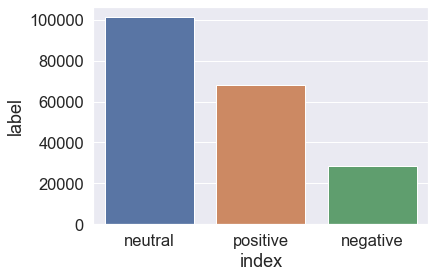

In [17]:
sns.set(font_scale=1.5)
sns.barplot(data=counts_df, x='index', y='label')

What if we include only verified tweets?

In [18]:
verified_counts = data.loc[data['user_verified'] == True].label.value_counts().reset_index()
verified_counts

index  label
0   neutral   8894
1  positive   5592
2  negative   2104

<AxesSubplot:xlabel='index', ylabel='label'>

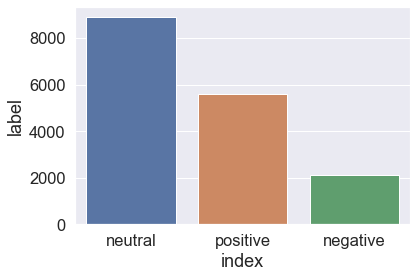

In [19]:
sns.barplot(data=verified_counts, x='index', y='label')

The ratio of positive to negative tweets is slightly higher for verified accounts, but overall they are pretty similar. Overall, neutral tweets outnumber the tweets with charged sentiments, and positive tweets outnumber negative tweets. What if we look at sentiment over time? We'll group the data by date and sentiment, and then count how many tweets of each sentiment there were on each day.

In [20]:
data_agg = data[['user_name', 'date', 'label']].groupby(['date', 'label']).count().reset_index()
data_agg.columns = ['date', 'label', 'counts']
data_agg.head()

date     label  counts
0 2020-12-12  negative       9
1 2020-12-12   neutral      29
2 2020-12-12  positive      25
3 2020-12-13  negative      13
4 2020-12-13   neutral      47

In [21]:
import plotly.express as px
px.line(data_agg, x='date', y='counts', color='label', title='Sentiment Over Time')

Overall counts started increasing in February of 2021, which makes sense since that's when the vaccines started to rollout. There is a curious dip in May 2021 for all three labels, indicating that perhaps the dataset we're working with is missing information during that time. Negative tweets seem to stay out the bottom of the three, except for a spike in August 2021, which might be interesting to look at further.

So far we've been looking at the whole dataset's sentiment scores, but what if we look at some measures of impact, such as number of favorites, retweets, and follower counts?

In [22]:
data_fav = data.groupby(['label']).favorites.sum().reset_index()
data_fav.head()

label  favorites
0  negative     227862
1   neutral     927488
2  positive     881638

[Text(0.5, 1.0, 'Number of favorites per sentiment')]

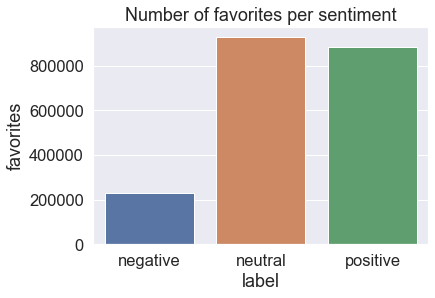

In [23]:
sns.barplot(data=data_fav, x='label', y='favorites').set(title='Number of favorites per sentiment')

In [24]:
data_retwt = data.groupby(['label']).retweets.sum().reset_index()
data_retwt.head()

label  retweets
0  negative     68989
1   neutral    206587
2  positive    195789

[Text(0.5, 1.0, 'Number of retweets per sentiment')]

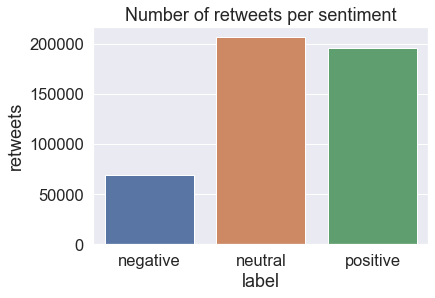

In [25]:
sns.barplot(data=data_retwt, x='label', y='retweets').set(title='Number of retweets per sentiment')

In [26]:
data_uf = data.groupby(['label']).user_followers.sum().reset_index()
data_uf.head()

label  user_followers
0  negative      2196850994
1   neutral     10139506555
2  positive      5916583201

[Text(0.5, 1.0, 'Number of followers per sentiment')]

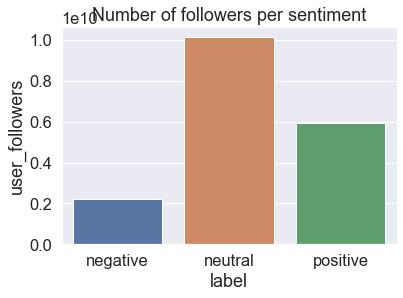

In [27]:
sns.barplot(data=data_uf, x='label', y='user_followers').set(title='Number of followers per sentiment')

Interestingly, the number of favorites and retweets of positive tweets vastly outnumbers negative tweets. Neutral tweets remain the most favorited and retweeted, but this analysis shows that positive tweets may be having more of an impact than negative tweets, and more than what was suggested by looking at number of tweets per sentiment. The number of followers analysis suggests something similar, though the difference between positive and negative is smaller.

We can also look at the top 10 retweeted, favorited, and followers and see what the labels look like.

In [28]:
df_rt = data.sort_values(by=['retweets'], ascending=False)
df_rt.head(10)

user_name  user_verified  user_followers       date  \
68358             Sputnik V           True          341843 2021-04-20   
46053        hotvickkrishna          False            5197 2021-04-01   
54674         BharatBiotech           True           58137 2021-04-08   
66822                  ICMR           True          222337 2021-04-21   
68306             Sputnik V           True          341843 2021-04-20   
76306             Sputnik V           True          513979 2021-05-19   
17118     Dr. S. Jaishankar           True          962016 2021-03-01   
53045             dawnymock          False            4493 2021-04-12   
75232          B L Santhosh           True          252773 2021-05-17   
7126   Robert F. Kennedy Jr           True          224642 2021-02-10   

                                                    text  retweets  favorites  \
68358  rdif laboratorios richmond launched production...     11288      25724   
46053  need two doses mrna 💉 vaccines pfizer moderna ...      7695      19622   
54674  completely reject false malicious reporting cn...      6018      15944   
66822  icmr study shows covaxin neutralises multiple ...      4851      11995   
68306  argentine health minister carlavizzotti presid...      4105      15148   
76306  argentinas actor breaks live tv show sputnikv ...      2550      14412   
17118  got jab curious covaxin felt secure travel safely      2360      22815   
53045  see it’s going around signature croppedso orig...      2299      10175   
75232  it’s 72 hours since bharatbiotech announced tr...      2294       7030   
7126   new research published microbiology amp infect...      2247       3090   

          label  
68358  positive  
46053   neutral  
54674  negative  
66822  positive  
68306  positive  
76306  positive  
17118  positive  
53045  positive  
75232   neutral  
7126   negative

In [29]:
df_f = data.sort_values(by=['favorites'], ascending = False)
df_f.head(10)

user_name  user_verified  user_followers       date  \
68358          Sputnik V           True          341843 2021-04-20   
17118  Dr. S. Jaishankar           True          962016 2021-03-01   
46053     hotvickkrishna          False            5197 2021-04-01   
54674      BharatBiotech           True           58137 2021-04-08   
68306          Sputnik V           True          341843 2021-04-20   
76306          Sputnik V           True          513979 2021-05-19   
57796          Sputnik V           True          326989 2021-04-12   
55541   Sudhir Chaudhary           True         6204294 2021-04-12   
66822               ICMR           True          222337 2021-04-21   
53045          dawnymock          False            4493 2021-04-12   

                                                    text  retweets  favorites  \
68358  rdif laboratorios richmond launched production...     11288      25724   
17118  got jab curious covaxin felt secure travel safely      2360      22815   
46053  need two doses mrna 💉 vaccines pfizer moderna ...      7695      19622   
54674  completely reject false malicious reporting cn...      6018      15944   
68306  argentine health minister carlavizzotti presid...      4105      15148   
76306  argentinas actor breaks live tv show sputnikv ...      2550      14412   
57796  breaking india world’s 2nd populous nation bec...      1642      13570   
55541  breaking news sputnikv approved emergency use ...      1389      12386   
66822  icmr study shows covaxin neutralises multiple ...      4851      11995   
53045  see it’s going around signature croppedso orig...      2299      10175   

          label  
68358  positive  
17118  positive  
46053   neutral  
54674  negative  
68306  positive  
76306  positive  
57796   neutral  
55541  positive  
66822  positive  
53045  positive

In [30]:
df_f = data.sort_values(by=['user_followers'], ascending = False)
df_f = df_f.drop_duplicates('user_name')
df_f.head(10)

user_name  user_verified  user_followers       date  \
195777                NDTV           True        16145870 2021-09-28   
1121                  CGTN           True        13714928 2020-12-25   
104448  The Times Of India           True        13671306 2021-06-17   
5464     China Xinhua News           True        12533116 2021-02-08   
54511             ABP News           True        11055384 2021-04-09   
195653           TIMES NOW           True        10088092 2021-09-28   
197305     Hindustan Times           True         8222725 2021-09-29   
20411       Shashi Tharoor           True         7955996 2021-03-03   
99208              Vir Das           True         7809929 2021-06-11   
70562         ABS-CBN News           True         7412071 2021-05-18   

                                                     text  retweets  \
195777  whos covaxin clearance delayed technical queri...         9   
1121    french national authority health said thursday...        12   
104448  covaxin bharat biotech world health organisati...        25   
5464    1st batch chinadonated sinopharm vaccines arri...        10   
54511   live covaxin doses go stock mumbai 25 inoculat...        10   
195653  newsalert seeks data covaxin asks data bharat ...         4   
197305  indias private hospitals cancelled orders russ...         3   
20411   like concerned covaxin deployed third phase tr...       100   
99208   taken covaxin recommend tagging handles bharat...       557   
70562   jmnpunzalan galvez clarifies 500000 sinovac ja...         4   

        favorites     label  
195777         39  negative  
1121           38  positive  
104448        271   neutral  
5464           30   neutral  
54511          50  negative  
195653         25   neutral  
197305         10  negative  
20411         695  positive  
99208        3385  positive  
70562           8  positive

Interestingly, positive tweets show up the most in the top 10 most retweeted and favorited tweets, with 6 out of 10 of the most retweeted labeled as positive, 2 out of 10 negative, and 2 out of 10 neutral. For most favorited tweets, it is 7 out of 10 labeled positive, 1 out of 10 negative, and 2 out of 10 as neutral. This strengthens the argument that positive tweets tend to be retweeted and favorited more than negative tweets. The number of followers for each tweet sentiment leaves things more ambiguous, but overall it seems that positive tweets may have more an impact/reach than negative tweets.

We can visualize some of the most used words for each sentiment using word clouds, so let's attempt to do that.

In [31]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [32]:
from wordcloud import WordCloud

(-0.5, 999.5, 499.5, -0.5)

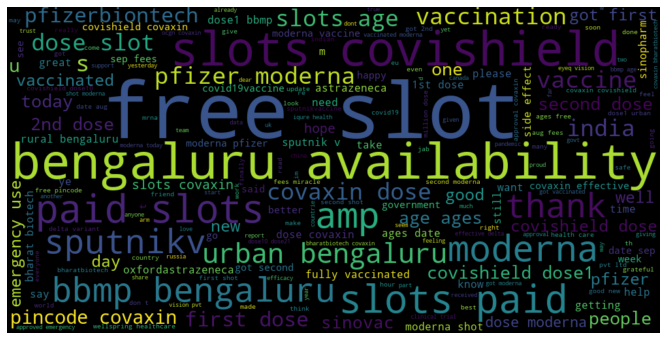

In [33]:
positive = data[data['label']=='positive']
words = ' '.join([word for word in positive['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

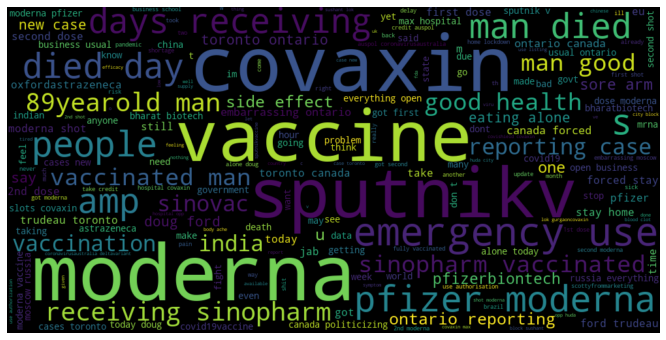

In [34]:
negative = data[data['label']=='negative']
words = ' '.join([word for word in negative['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

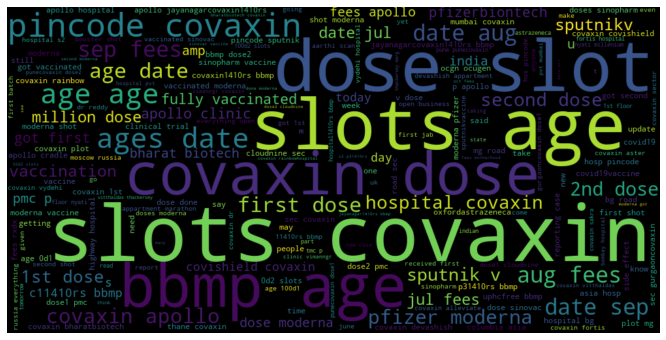

In [35]:
neutral = data[data['label']=='neutral']
words = ' '.join([word for word in neutral['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')